<div align="center">
<a href="https://vbti.nl"><img src="./images/vbti_logo.png" width="400"></a>
</div>

# Double Q-learning [paper]

The max operator in DQN uses the same values both to select an action and to evaluate it. This dependency makes it more likely to select overestimated values, which results in overoptimistic value estimates. The authors show that as the number of actions grows, the overestimation bias increases, which prevents learning or results in very slow convergence. The main idea of Double Q-learning is to decouple selection and evaluation processes by maintaining two Q-functions for selecting an action and evaluating it.

The algorithm works almost the same as the vanilla version in the previous notebook but with a small variation. Now the best action is given, as previously, by an online network (parameterized by $\theta$), while the target network (with parameters $\theta'$) estimates the value of an action:

$$L_i(\theta_i) = \mathbb{E}[(y_i - Q(s,a;\theta_i)^2)]$$

$$y_i=r+\gamma \max_{a'}Q(s',a';\theta'_{i-1})$$

The weights of the online network are copied over to the target network every $\tau$ steps. The value estimation now lags behind the behavioral policy, which considerably speeds up the training.

To make the necessary code adjustments, we would need to first create an additional target network in the ```__init__()``` method and override the ```get_best_action_value``` to get the value estimation from the target network. Then we need to update the target network every $\tau$ steps, which is the ```target_network_update_freq``` parameter.

```python
class DoubleDQN(DeepQNetwork):
    def __init__(self, target_network_update_freq=8000, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.target_network_update_freq = target_network_update_freq
      
        self.target_network = self.create_model('target_dqn')
        
        # At the begining of the training set the same weights to both networks
        self.hard_update_target_network()
        self.steps = 0

    @tf.function
    def get_best_action_value(self, state):
        return tf.reduce_max(self.target_network(state), axis=1)

    def update(self, *args, **kwargs):
        loss = super().update(*args, **kwargs)
        if self.steps % self.target_network_update_freq == 0:
            self.hard_update_target_network()
        self.steps += 1
        return loss

```

## Pong
### Load

Lets try this algorithm on Pong. All the parameters are left the same, and we set ```target_network_update_freq=500```, which would update our target network every 500 steps.

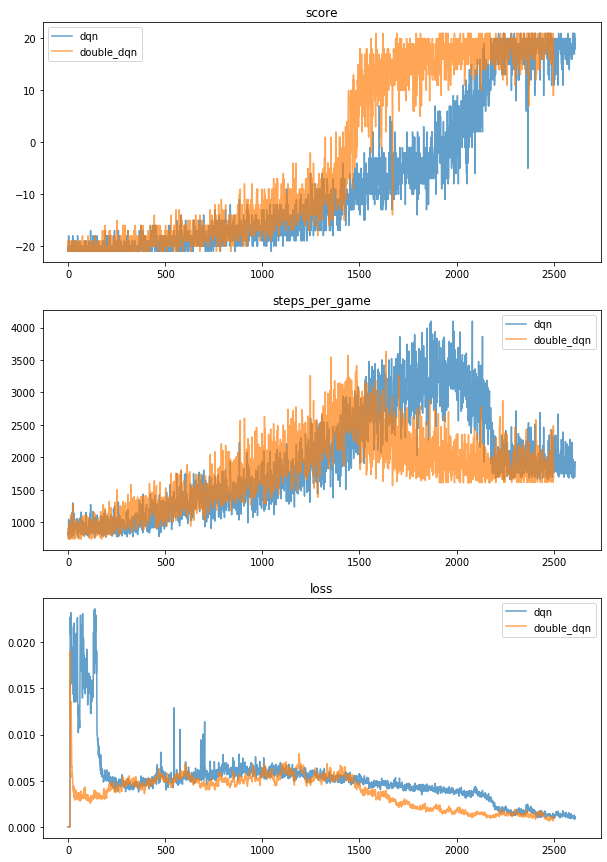

In [1]:
from dqn import load_history, plot_history
import matplotlib.pyplot as plt

from os.path import join

history_ddqn = load_history(join('Experiments', 'pong_double_dqn', 'history.json'))
history_dqn = load_history(join('Experiments', 'pong_dqn', 'history.json'))

elems = ['score', 'steps_per_game', 'loss']

plot_history([history_dqn, history_ddqn], elems, names=['dqn', 'double_dqn'])

The vanilla DQN got to 20 points after 2000 episodes, but Double DQN was able to reach the same point before 1500 episodes. This speed up is going to be even more noticeable when we need to solve more challenging environments when we need to train up to 20000 thousand episodes.

In [2]:
from os.path import join

import gym

from dqn import EpsilonGreedyAgent, DeepQNetwork
from env_wrappers import AtariFrameStack

EXPERIMENT_FOLDER = join('Experiments', 'pong_double_dqn')

env = AtariFrameStack(gym.make('PongNoFrameskip-v4'))
q_network = DeepQNetwork(state_shape=env.observation_space.shape,
                         n_actions=env.action_space.n)
# Load the network
q_network.load(join(EXPERIMENT_FOLDER, 'latest'))

agent = EpsilonGreedyAgent(n_actions=env.action_space.n, network=q_network, start_epsilon=0.02)

In [3]:
from dqn import run_episode

video_path = join(EXPERIMENT_FOLDER, 'videos')
                  
env = gym.wrappers.Monitor(env, video_path, force=True)
print(run_episode(env, agent, train=False))
env.close()

{'score': 20.0, 'steps_per_game': 1705, 'framerate': 264.60762312252825, 'runs': 0, 'return': 0, 'epsilon': 0.02, 'loss': 0, 'steps': 0}


In [4]:
from IPython.display import Video
import os

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name))

### Train

In [3]:
import gym
from env_wrappers import AtariFrameStack
from dqn import EpsilonGreedyAgent, DoubleDQN

EXPERIMENT_FOLDER = join('Experiments', 'pong_double_dqn_01')

env = AtariFrameStack(gym.make('PongNoFrameskip-v4'),
                      frame_skip=4,
                      terminal_on_life_loss=False,
                      screen_size=84,
                      stack_size=4,
                      skip_init=20)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DoubleDQN(state_shape=env.observation_space.shape,
                        target_network_update_freq=500,
                         n_actions=env.action_space.n,
                         learning_rate=6.25e-5,
                         gamma=0.99)

agent = EpsilonGreedyAgent(n_actions=env.action_space.n,
                   network=q_network,
                   replay_capacity=50000,
                   gamma=0.99,  # discount of future rewards
                   training_start=10000,  # start training after x number of steps
                   training_interval=4,  # train every x steps
                   batch_size=32,
                   start_epsilon=1.0,
                   end_epsilon=0.02,
                   epsilon_decay=1e-6,
                   root_folder=EXPERIMENT_FOLDER,
                   save_best=True,
                   save_interval=100)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(84, 84, 4)
Action space: Discrete(6)


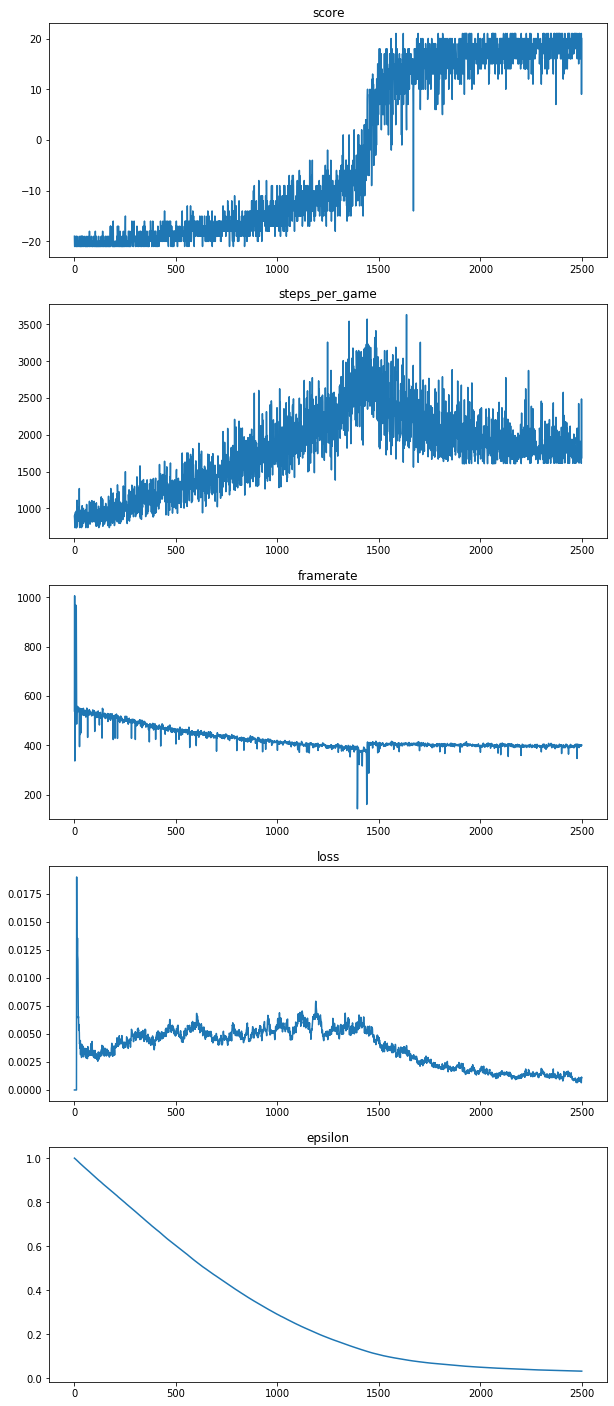

In [6]:
from dqn import run_experiment

run_experiment(env, agent, runs=2500, history=history)
env.close()

### Save

In [10]:
from os.path import join
import json
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))
json.dump(str(history), open(join(EXPERIMENT_FOLDER, 'history.json'), 'w'))

INFO:tensorflow:Assets written to: pong_double_dqn/latest/assets


## Seaquest

Lets apply the same algorithm on a more challenging environment.

In [6]:
import gym

env = gym.make('SeaquestNoFrameskip-v4')
print('Observation shape:', env.observation_space.shape)
print('Number of actions:', env.action_space.n)
print('Action meaning', env.unwrapped.get_action_meanings())

Observation shape: (210, 160, 3)
Number of actions: 18
Action meaning ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


### Train

In [28]:
import gym
from env_wrappers import AtariFrameStack
from dqn import DuelingDDQN

EXPERIMENT_FOLDER = join('Experiments', 'seaquest_double_dqn_01')
save_interval = 500
video_folder = join(EXPERIMENT_FOLDER, 'video')

env = AtariFrameStack(gym.make('SeaquestNoFrameskip-v4'),
                      frame_skip=4,
                      terminal_on_life_loss=False,
                      screen_size=84,
                      stack_size=4,
                      skip_init=20)
env = gym.wrappers.Monitor(env, video_folder, force=True,
                          video_callable=lambda episode_id: episode_id % save_interval == 0)
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DoubleDQN(state_shape=env.observation_space.shape,
                        target_network_update_freq=8000,
                         n_actions=env.action_space.n,
                         learning_rate=6.25e-5,
                         gamma=0.99)

agent = EpsilonGreedyAgent(n_actions=env.action_space.n,
                   network=q_network,
                   replay_capacity=50000,
                   gamma=0.99,  # discount of future rewards
                   training_start=10000,  # start training after x number of steps
                   training_interval=4,  # train every x steps
                   batch_size=32,
                   start_epsilon=1.0,
                   end_epsilon=0.02,
                   epsilon_decay=2e-7,
                   root_folder=EXPERIMENT_FOLDER,
                   save_best=True,
                   save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(84, 84, 4)
Action space: Discrete(18)


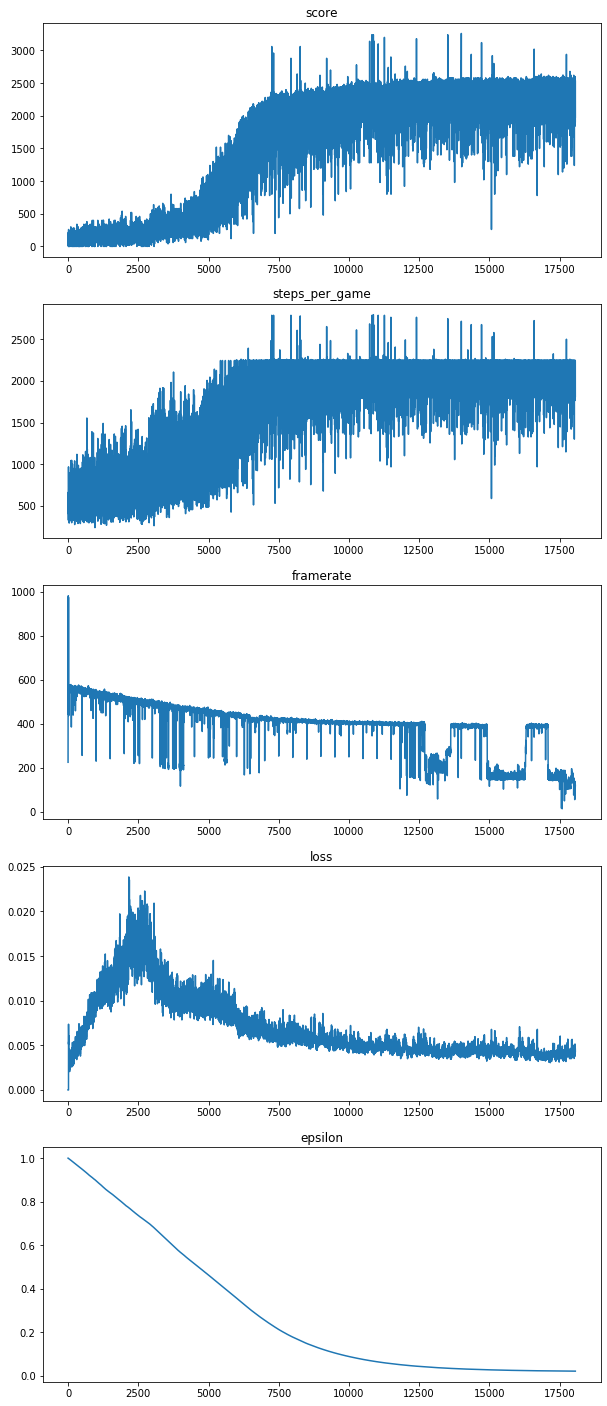

In [ ]:
from dqn import run_experiment

run_experiment(env, agent, runs=20000, history=history)
env.close()

By looking at the *score* and *steps_per_game* you might have noticed something interesting is going on. It seems like the agent hit a learning obstacle it cannot overcome. Lets have a look at the at video of the agent playing.

In [31]:
from IPython.display import Video
Video("GIF/double_dqn_seaquest_2520.mp4")

It seems that the agent never learned how to take a breath of fresh air. By looking at the spikes in the *steps_per_game*, we can assume that the agent did stumble upon the breathing mechanic, but it never learned how to exploit it. As a solution, we could increase the exploration period, but that would result in longer training times. Since breathing is a very rewarding experience, we can modify the algorithm a bit, so that agent can focus on those actions that result in higher rewards in comparison to other actions. In the next notebook, we will have a look at a smarter network architecture that can achieve that.

# Assigment

If you've solved Pong you're ready to go to the next game: Breakout. Train your own DQN to play Breakout.

# References

[1] Richard Sutton & Andrew Barto, Reinforcement Learning – An Introduction, november 2018
